In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from IPython.display import display # Allows the use of display() for DataFrames
%matplotlib inline

In [3]:
df=pd.read_csv("../demographics.csv")
df.head(5)

,Gender,Age,MaritalStatus,NuChildren,ResidencyDist,Ubudehe,StudentStatus,EducationLvl,LastSchoolCat,HTLast3yrs,EmployedLast1yr,OccupancyStatus
0,Male,31,Married,1-2,Nyarugenge,2.0,No,Senior 6,Public school,No,No,Owner occupier
1,Male,33,Single,None,Nyarugenge,2.0,No,Bachelor degree,Private school,Yes,No,Owner occupier
2,Male,26,Single,None,Nyamasheke,3.0,No,Senior 6,Private school,No,Yes,Tenancy – Renting
3,Male,23,Single,None,Nyarugenge,2.0,No,Senior 6,Private school,Yes,Yes,Tenancy – Renting
4,Female,24,Single,None,Gasabo,3.0,No,Senior 6,Private school,Yes,No,Dwelling (house) provided free of charge


# Data Exploration

12 columns, mostly categorical data - Only numeric data is Ubudehe



In [4]:
df.describe()

,Ubudehe
count,888.000000
mean,2.498874
std,0.666478
min,1.000000
25%,2.000000
50%,3.000000
75%,3.000000
max,6.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 12 columns):
Gender             925 non-null object
Age                925 non-null object
MaritalStatus      925 non-null object
NuChildren         925 non-null object
ResidencyDist      888 non-null object
Ubudehe            888 non-null float64
StudentStatus      888 non-null object
EducationLvl       844 non-null object
LastSchoolCat      860 non-null object
HTLast3yrs         860 non-null object
EmployedLast1yr    860 non-null object
OccupancyStatus    786 non-null object
dtypes: float64(1), object(11)
memory usage: 86.8+ KB


In [6]:
#Due to improper data entry, some ages were 0.. The mean of the correctly entered ones is 34. 
df.Age.replace({"0":30, "#NUM!":32,"05/18/1994":26}, inplace=True)

In [7]:
df.mode()

,Gender,Age,MaritalStatus,NuChildren,ResidencyDist,Ubudehe,StudentStatus,EducationLvl,LastSchoolCat,HTLast3yrs,EmployedLast1yr,OccupancyStatus
0,Male,30,Single,None,Gasabo,3.0,No,Senior 6,Private school,No,Yes,Tenancy – Renting


1. The most rep gender is Male
2. Most frequent age is 30 -for obvious reasons
3. Number of children - None
4. Gasabo
5. Ubudehe 3
6. Last school cat= Private
7. Educations- senior 6
8. Employed - Yes
9. Occupancy -Tenant Renting
10. HT = No
11. single

In [9]:
df=df.fillna(df.mode())

In [10]:
null=df.isnull().any()
null_index=list(null.index)
null_index
list(null)

[False, False, False, False, True, True, True, True, True, True, True, True]

In [11]:
df.isnull().sum()

Gender               0
Age                  0
MaritalStatus        0
NuChildren           0
ResidencyDist       37
Ubudehe             37
StudentStatus       37
EducationLvl        81
LastSchoolCat       65
HTLast3yrs          65
EmployedLast1yr     65
OccupancyStatus    139
dtype: int64

In [15]:
# Filling in null with the mode
for i in range(len(null_index)):
    if null[i]==True:
        df[null_index[i]]= df[null_index[i]].fillna(df[null_index[i]].mode()[0])

In [16]:
df.Age=pd.to_numeric(df.Age)

In [12]:
from collections import defaultdict

encoder=defaultdict(LabelEncoder)
encoder

defaultdict(sklearn.preprocessing.label.LabelEncoder, {})

In [17]:
fit=df.loc[:, ['Gender',  'MaritalStatus', 'NuChildren', 'ResidencyDist',
       'StudentStatus', 'EducationLvl', 'LastSchoolCat',
       'HTLast3yrs', 'EmployedLast1yr', 'OccupancyStatus']].apply(lambda x:encoder[x.name].fit_transform(x))
fit.head()

,Gender,MaritalStatus,NuChildren,ResidencyDist,StudentStatus,EducationLvl,LastSchoolCat,HTLast3yrs,EmployedLast1yr,OccupancyStatus
0,1,0,0,20,0,13,2,0,0,3
1,1,1,4,20,0,5,0,1,0,3
2,1,1,4,18,0,13,0,0,1,5
3,1,1,4,20,0,13,0,1,1,5
4,0,1,4,2,0,13,0,1,0,2


In [18]:
new_df=fit.copy()+1  # will do log transformation which doesn't work with zeros
new_df["Age"]=df.Age
new_df["Ubudehe"]=df.Ubudehe
new_df.head()

,Gender,MaritalStatus,NuChildren,ResidencyDist,StudentStatus,EducationLvl,LastSchoolCat,HTLast3yrs,EmployedLast1yr,OccupancyStatus,Age,Ubudehe
0,2,1,1,21,1,14,3,1,1,4,31,2.0
1,2,2,5,21,1,6,1,2,1,4,33,2.0
2,2,2,5,19,1,14,1,1,2,6,26,3.0
3,2,2,5,21,1,14,1,2,2,6,23,2.0
4,1,2,5,3,1,14,1,2,1,3,24,3.0


In [84]:
df.columns

Index(['Gender', 'Age', 'MaritalStatus', 'NuChildren', 'ResidencyDist',
       'Ubudehe', 'StudentStatus', 'EducationLvl', 'LastSchoolCat',
       'HTLast3yrs', 'EmployedLast1yr', 'OccupancyStatus'],
      dtype='object')

In [19]:
new_df.describe()

,Gender,MaritalStatus,NuChildren,ResidencyDist,StudentStatus,EducationLvl,LastSchoolCat,HTLast3yrs,EmployedLast1yr,OccupancyStatus,Age,Ubudehe
count,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000
mean,1.525405,1.943784,4.698378,11.020541,1.309189,9.949189,1.902703,1.422703,1.603243,4.732973,34.001081,2.518919
std,0.499624,0.239671,1.036586,7.516836,0.462409,4.755108,0.954168,0.494256,0.489489,1.339156,261.394477,0.660348
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,5.000000,3.000000,1.000000,6.000000,1.000000,1.000000,1.000000,4.000000,22.000000,2.000000
50%,2.000000,2.000000,5.000000,11.000000,1.000000,14.000000,1.000000,1.000000,2.000000,5.000000,26.000000,3.000000
75%,2.000000,2.000000,5.000000,21.000000,2.000000,14.000000,3.000000,2.000000,2.000000,6.000000,30.000000,3.000000
max,2.000000,3.000000,5.000000,28.000000,2.000000,14.000000,3.000000,2.000000,2.000000,6.000000,7973.000000,6.000000


In [20]:
data=new_df

In [21]:
data.corr()

,Gender,MaritalStatus,NuChildren,ResidencyDist,StudentStatus,EducationLvl,LastSchoolCat,HTLast3yrs,EmployedLast1yr,OccupancyStatus,Age,Ubudehe
Gender,1.000000,-0.060364,-0.028027,0.050723,-0.052775,-0.022461,0.091457,0.085752,0.140829,0.166242,-0.030492,-0.108888
MaritalStatus,-0.060364,1.000000,0.694009,0.006048,0.078882,0.028829,0.028113,-0.128083,-0.061175,-0.073796,0.003076,-0.000111
NuChildren,-0.028027,0.694009,1.000000,-0.008093,0.057042,0.054852,0.041420,-0.137444,-0.050540,-0.094726,0.005042,0.069216
ResidencyDist,0.050723,0.006048,-0.008093,1.000000,0.044253,-0.027282,0.050526,0.059416,-0.023078,-0.046008,0.044243,0.007444
StudentStatus,-0.052775,0.078882,0.057042,0.044253,1.000000,-0.021395,0.060898,-0.075258,-0.122058,0.035600,0.045527,-0.026266
EducationLvl,-0.022461,0.028829,0.054852,-0.027282,-0.021395,1.000000,-0.105328,-0.060385,0.054100,-0.019638,-0.030778,0.049421
LastSchoolCat,0.091457,0.028113,0.041420,0.050526,0.060898,-0.105328,1.000000,-0.029734,-0.045667,-0.017814,-0.031940,-0.120745
HTLast3yrs,0.085752,-0.128083,-0.137444,0.059416,-0.075258,-0.060385,-0.029734,1.000000,0.300304,0.061165,-0.026307,-0.019555
EmployedLast1yr,0.140829,-0.061175,-0.050540,-0.023078,-0.122058,0.054100,-0.045667,0.300304,1.000000,0.171708,0.028347,0.055055
OccupancyStatus,0.166242,-0.073796,-0.094726,-0.046008,0.035600,-0.019638,-0.017814,0.061165,0.171708,1.000000,0.033410,-0.097695


In [22]:
samples=data.iloc[[10, 400, 293],:]

In [65]:
samples_raw=df.iloc[[10, 400, 293],:]
samples_raw
samples.to_csv("samples.csv")

In [23]:
samples

,Gender,MaritalStatus,NuChildren,ResidencyDist,StudentStatus,EducationLvl,LastSchoolCat,HTLast3yrs,EmployedLast1yr,OccupancyStatus,Age,Ubudehe
10,2,1,1,13,2,14,3,1,1,4,31,2.0
400,1,2,5,3,1,14,2,2,2,6,30,3.0
293,1,2,5,21,1,6,1,2,2,5,28,3.0


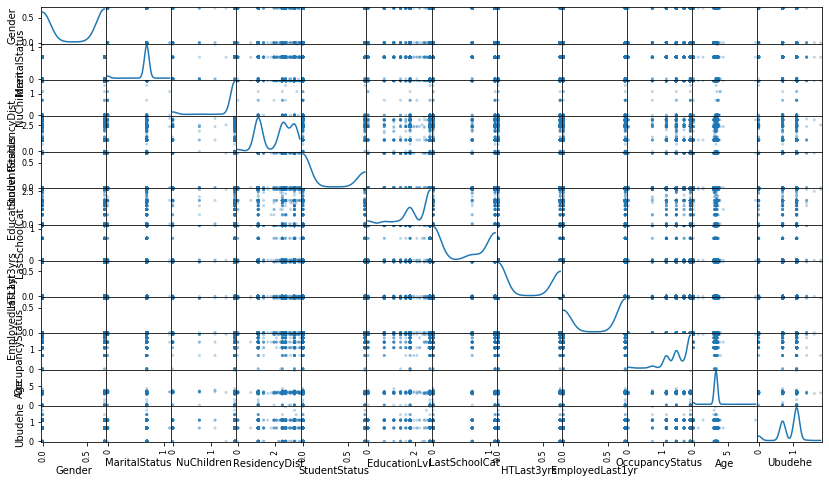

In [24]:
# TODO: Scale the data using the natural logarithm
log_data = np.log(data)

# TODO: Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.plotting.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [25]:
# Select the indices for data points you wish to remove
import itertools
outliers_lst  = []

# For each feature find the data points with extreme high or low values
for feature in log_data.columns:
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data.loc[:, feature], 25)

    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data.loc[:, feature], 75)

    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5 * (Q3 - Q1)

    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))

    # The tilde sign ~ means not
    # So here, we're finding any points outside of Q1 - step and Q3 + step
    outliers_rows = log_data.loc[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step)), :]
    # display(outliers_rows)

    outliers_lst.append(list(outliers_rows.index))

outliers = list(itertools.chain.from_iterable(outliers_lst))

# List of unique outliers
# We use set()
# Sets are lists with no duplicate entries
uniq_outliers = list(set(outliers))

# List of duplicate outliers
dup_outliers = list(set([x for x in outliers if outliers.count(x) > 1]))

print('Outliers list:\n', uniq_outliers)
print('Length of outliers list:\n', len(uniq_outliers))

print('Duplicate list:\n', dup_outliers)
print('Length of duplicates list:\n', len(dup_outliers))

# Remove duplicate outliers
# Only 5 specified
good_data = log_data.drop(log_data.index[dup_outliers]).reset_index(drop = True)

# Original Data 
print('Original shape of data:\n', data.shape)
# Processed Data
print('New shape of data:\n', good_data.shape)


Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'MaritalStatus':
Data points considered outliers for the feature 'NuChildren':
Data points considered outliers for the feature 'ResidencyDist':
Data points considered outliers for the feature 'StudentStatus':
Data points considered outliers for the feature 'EducationLvl':
Data points considered outliers for the feature 'LastSchoolCat':
Data points considered outliers for the feature 'HTLast3yrs':
Data points considered outliers for the feature 'EmployedLast1yr':
Data points considered outliers for the feature 'OccupancyStatus':
Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Ubudehe':
Outliers list:
 [0, 512, 516, 7, 9, 10, 523, 13, 525, 15, 527, 17, 526, 529, 20, 532, 534, 535, 27, 540, 544, 546, 35, 553, 42, 554, 559, 48, 563, 53, 565, 568, 570, 571, 62, 66, 579, 68, 70, 584, 585, 587, 588, 78, 79, 80, 597, 599, 89, 90, 604,

In [26]:
from sklearn.decomposition import PCA

# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
# Instantiate
pca = PCA(n_components=4)
# Fit
pca.fit(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_samples

array([[-0.5334558 , -0.37512027,  0.25532948, -0.67887735],
       [ 1.00203774, -0.41617393,  0.30183755, -0.23926721],
       [-0.91864294,  0.24581163,  0.20779759,  0.67829066]])

In [28]:
# Instantiate
pca = PCA(n_components=3)
pca.fit(good_data)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2', "Dimension 3"])

In [29]:
pca_samples

array([[-0.5334558 , -0.37512027,  0.25532948],
       [ 1.00203774, -0.41617393,  0.30183755],
       [-0.91864294,  0.24581163,  0.20779759]])

In [31]:
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2',"Dimension 3"]))


,Dimension 1,Dimension 2,Dimension 3
0,-0.5335,-0.3751,0.2553
1,1.0020,-0.4162,0.3018
2,-0.9186,0.2458,0.2078


In [32]:
# Create range of clusters 
range_n_clusters = list(range(2,11))
print(range_n_clusters)

[2, 3, 4, 5, 6, 7, 8, 9, 10]


In [33]:
# Loop through clusters
for n_clusters in range_n_clusters:
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = GaussianMixture(n_components=n_clusters).fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TODO: Find the cluster centers
    centers = clusterer.means_

    # TODO: Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, metric='mahalanobis')
    print("For n_clusters = {}. The average silhouette_score is : {}".format(n_clusters, score))

For n_clusters = 2. The average silhouette_score is : 0.41833394856527906
For n_clusters = 3. The average silhouette_score is : 0.4132278752500837
For n_clusters = 4. The average silhouette_score is : 0.4050329295258189
For n_clusters = 5. The average silhouette_score is : 0.4912055084302478
For n_clusters = 6. The average silhouette_score is : 0.48733995919338424
For n_clusters = 7. The average silhouette_score is : 0.49255891026152626
For n_clusters = 8. The average silhouette_score is : 0.40026215368040674
For n_clusters = 9. The average silhouette_score is : 0.45431713006076635
For n_clusters = 10. The average silhouette_score is : 0.27509940011452505


In [34]:
# Loop through clusters
for n_clusters in range_n_clusters:
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = KMeans(n_clusters=n_clusters).fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TODO: Find the cluster centers
    centers = clusterer.cluster_centers_

    # TODO: Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, metric='euclidean')
    print("For n_clusters = {}. The average silhouette_score is : {}".format(n_clusters, score))

For n_clusters = 2. The average silhouette_score is : 0.49000642121664967
For n_clusters = 3. The average silhouette_score is : 0.5253847657536495
For n_clusters = 4. The average silhouette_score is : 0.5462918343936256
For n_clusters = 5. The average silhouette_score is : 0.5316811109171529
For n_clusters = 6. The average silhouette_score is : 0.5380839736832498
For n_clusters = 7. The average silhouette_score is : 0.5489980097875152
For n_clusters = 8. The average silhouette_score is : 0.5473067831630976
For n_clusters = 9. The average silhouette_score is : 0.5704443646529741
For n_clusters = 10. The average silhouette_score is : 0.5755591943326266


In [54]:
clusterer = GaussianMixture(n_components=2).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.means_
sample_preds = clusterer.predict(pca_samples)


In [40]:
import matplotlib.cm as cm

def cluster_results(reduced_data, preds, centers, pca_samples):
	'''
	Visualizes the PCA-reduced cluster data in two dimensions
	Adds cues for cluster centers and student-selected sample data
	'''

	predictions = pd.DataFrame(preds, columns = ['Cluster'])
	plot_data = pd.concat([predictions, reduced_data], axis = 1)

	# Generate the cluster plot
	fig, ax = plt.subplots(figsize = (14,8))

	# Color map
	cmap = cm.get_cmap('gist_rainbow')

	# Color the points based on assigned cluster
	for i, cluster in plot_data.groupby('Cluster'):   
	    cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
	                 color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

	# Plot centers with indicators
	for i, c in enumerate(centers):
	    ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
	               alpha = 1, linewidth = 2, marker = 'o', s=200);
	    ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

	# Plot transformed sample points 
	ax.scatter(x = pca_samples[:,0], y = pca_samples[:,1], \
	           s = 150, linewidth = 4, color = 'black', marker = 'x');

	# Set plot title
	ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");

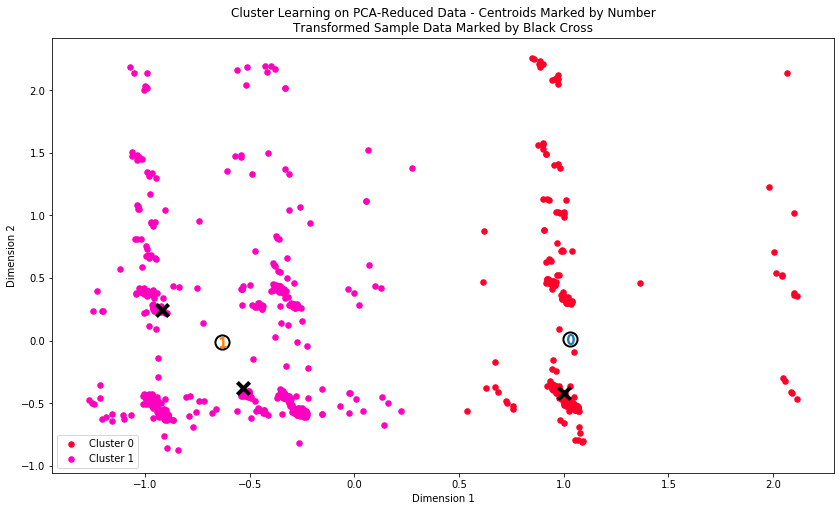

In [55]:
cluster_results(reduced_data, preds, centers, pca_samples)

In [56]:
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)


# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.columns)
true_centers.index = segments
true_centers.loc[:, ['Gender',  'MaritalStatus', 'NuChildren', 'ResidencyDist',
       'StudentStatus', 'EducationLvl', 'LastSchoolCat',
       'HTLast3yrs', 'EmployedLast1yr', 'OccupancyStatus']]=true_centers.loc[:, ['Gender',  'MaritalStatus', 'NuChildren', 'ResidencyDist',
       'StudentStatus', 'EducationLvl', 'LastSchoolCat',
       'HTLast3yrs', 'EmployedLast1yr', 'OccupancyStatus']]-1

display(true_centers)

,Gender,MaritalStatus,NuChildren,ResidencyDist,StudentStatus,EducationLvl,LastSchoolCat,HTLast3yrs,EmployedLast1yr,OccupancyStatus,Age,Ubudehe
Segment 0,0.0,1.0,4.0,2.0,0.0,8.0,1.0,0.0,1.0,4.0,23.0,2.0
Segment 1,0.0,1.0,4.0,14.0,0.0,7.0,1.0,0.0,0.0,3.0,24.0,2.0


In [58]:
# Clusters' deviation from median
display(true_centers+1 - data.median())

# Clusters' deviation from mean
display(true_centers+1 - data.mean())

,Gender,MaritalStatus,NuChildren,ResidencyDist,StudentStatus,EducationLvl,LastSchoolCat,HTLast3yrs,EmployedLast1yr,OccupancyStatus,Age,Ubudehe
Segment 0,-1.0,0.0,0.0,-8.0,0.0,-5.0,1.0,0.0,0.0,0.0,-2.0,0.0
Segment 1,-1.0,0.0,0.0,4.0,0.0,-6.0,1.0,0.0,-1.0,-1.0,-1.0,0.0


,Gender,MaritalStatus,NuChildren,ResidencyDist,StudentStatus,EducationLvl,LastSchoolCat,HTLast3yrs,EmployedLast1yr,OccupancyStatus,Age,Ubudehe
Segment 0,-0.525405,0.056216,0.301622,-8.020541,-0.309189,-0.949189,0.097297,-0.422703,0.396757,0.267027,-10.001081,0.481081
Segment 1,-0.525405,0.056216,0.301622,3.979459,-0.309189,-1.949189,0.097297,-0.422703,-0.603243,-0.732973,-9.001081,0.481081


In [57]:
for i, pred in enumerate(sample_preds):
    print("Sample point", i, "predicted to be in Cluster", pred)

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 0
Sample point 2 predicted to be in Cluster 1


In [63]:
to_inverse=true_centers.loc[:, ['Gender',  'MaritalStatus', 'NuChildren', 'ResidencyDist',
       'StudentStatus', 'EducationLvl', 'LastSchoolCat',
       'HTLast3yrs', 'EmployedLast1yr', 'OccupancyStatus']]

to_inverse=to_inverse.astype(int).apply(lambda x:encoder[x.name].inverse_transform(x))
to_inverse["Age"]=true_centers["Age"]
to_inverse["Ubudehe"]=true_centers["Ubudehe"]
to_inverse.to_csv("two_clusters_centroids.csv")
to_inverse

,Gender,MaritalStatus,NuChildren,ResidencyDist,StudentStatus,EducationLvl,LastSchoolCat,HTLast3yrs,EmployedLast1yr,OccupancyStatus,Age,Ubudehe
Segment 0,Female,Single,None,Gasabo,No,Masters degree,Public aided school,No,Yes,Temporary camp or settlement,23.0,2.0
Segment 1,Female,Single,None,Ngororero,No,Certificate,Public aided school,No,No,Owner occupier,24.0,2.0


,Gender,MaritalStatus,NuChildren,ResidencyDist,StudentStatus,EducationLvl,LastSchoolCat,HTLast3yrs,EmployedLast1yr,OccupancyStatus,Age,Ubudehe
Segment 0,0.0,1.0,4.0,2.0,0.0,13.0,0.0,0.0,1.0,4.0,25.0,2.0
Segment 1,0.0,1.0,4.0,20.0,0.0,13.0,1.0,0.0,1.0,3.0,24.0,2.0
Segment 2,0.0,1.0,4.0,20.0,0.0,5.0,1.0,0.0,0.0,3.0,33.0,2.0
Segment 3,0.0,1.0,4.0,2.0,0.0,9.0,1.0,0.0,0.0,3.0,1.0,3.0
Segment 4,0.0,1.0,4.0,2.0,0.0,3.0,1.0,0.0,1.0,4.0,27.0,2.0
Segment 5,0.0,1.0,4.0,11.0,0.0,13.0,1.0,0.0,1.0,3.0,25.0,2.0
Segment 6,0.0,1.0,4.0,4.0,0.0,6.0,1.0,0.0,1.0,4.0,25.0,2.0
Segment 7,0.0,1.0,4.0,18.0,0.0,3.0,1.0,0.0,0.0,3.0,26.0,2.0
Segment 8,0.0,1.0,4.0,10.0,0.0,5.0,1.0,0.0,0.0,3.0,28.0,2.0
Segment 9,0.0,1.0,4.0,14.0,1.0,6.0,1.0,0.0,0.0,3.0,1.0,3.0


Sample point 0 predicted to be in Cluster 5
Sample point 1 predicted to be in Cluster 0
Sample point 2 predicted to be in Cluster 2


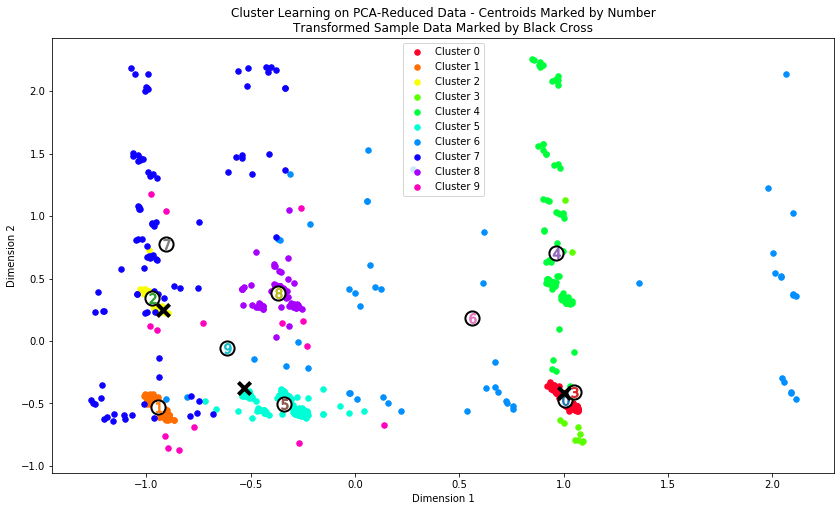

In [42]:
clusterer = GaussianMixture(n_components=10).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.means_
sample_preds = clusterer.predict(pca_samples)

cluster_results(reduced_data, preds, centers, pca_samples)

log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)


# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.columns)
true_centers.index = segments
true_centers.loc[:, ['Gender',  'MaritalStatus', 'NuChildren', 'ResidencyDist',
       'StudentStatus', 'EducationLvl', 'LastSchoolCat',
       'HTLast3yrs', 'EmployedLast1yr', 'OccupancyStatus']]=true_centers.loc[:, ['Gender',  'MaritalStatus', 'NuChildren', 'ResidencyDist',
       'StudentStatus', 'EducationLvl', 'LastSchoolCat',
       'HTLast3yrs', 'EmployedLast1yr', 'OccupancyStatus']]-1

display(true_centers)

for i, pred in enumerate(sample_preds):
    print("Sample point", i, "predicted to be in Cluster", pred)


In [46]:
to_inverse=true_centers.loc[:, ['Gender',  'MaritalStatus', 'NuChildren', 'ResidencyDist',
       'StudentStatus', 'EducationLvl', 'LastSchoolCat',
       'HTLast3yrs', 'EmployedLast1yr', 'OccupancyStatus']]

In [47]:
to_inverse=to_inverse.astype(int).apply(lambda x:encoder[x.name].inverse_transform(x))
to_inverse["Age"]=true_centers["Age"]
to_inverse["Ubudehe"]=true_centers["Ubudehe"]
to_inverse.to_csv("ten_clusters_centroids.csv")
to_inverse

,Gender,MaritalStatus,NuChildren,ResidencyDist,StudentStatus,EducationLvl,LastSchoolCat,HTLast3yrs,EmployedLast1yr,OccupancyStatus
Segment 0,Female,Single,None,Gasabo,No,Senior 6,Private school,No,Yes,Temporary camp or settlement
Segment 1,Female,Single,None,Nyarugenge,No,Senior 6,Public aided school,No,Yes,Owner occupier
Segment 2,Female,Single,None,Nyarugenge,No,Bachelor degree,Public aided school,No,No,Owner occupier
Segment 3,Female,Single,None,Gasabo,No,Primary,Public aided school,No,No,Owner occupier
Segment 4,Female,Single,None,Gasabo,No,Bachelor Year 2,Public aided school,No,Yes,Temporary camp or settlement
Segment 5,Female,Single,None,Muhanga,No,Senior 6,Public aided school,No,Yes,Owner occupier
Segment 6,Female,Single,None,Gicumbi,No,Bachelor year 2,Public aided school,No,Yes,Temporary camp or settlement
Segment 7,Female,Single,None,Nyamasheke,No,Bachelor Year 2,Public aided school,No,No,Owner occupier
Segment 8,Female,Single,None,Kicukiro,No,Bachelor degree,Public aided school,No,No,Owner occupier
Segment 9,Female,Single,None,Ngororero,Yes,Bachelor year 2,Public aided school,No,No,Owner occupier
